# predicting gentrification

The purpose of this notebook is to take a (very naive) first attempt at building a model that predicts gentrification given the tract-level census data.

To keep things simple, I will:

- Build a model that uses data from 1990 to predict the label `gent90_00`
- Using this model, try to use the data from 2000 to predict the label `gent00_10`.

One interesting thing you'll notice is that I do absolutely no data preprocessing, nor do I hand-select which features to feed into the model. In fact, I don't even know what the features are, or what they mean! (Don't worry, we can start to recover the "importance" of features down the line).

Hours:

In [1]:
# import jtplot module in notebook
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import itertools
from typing import Tuple, Dict, List
# if you get any complaints about missing dependencies, 
# comment out the line before the dependency to install it.
# (just remember to comment that line out again after installation)
# !pip3 install pandas
import pandas as pd
# !pip3 install funcy
from funcy import *
# !pip3 install numpy
import numpy as np
# Install instructions here: 
#   https://xgboost.readthedocs.io/en/latest/python/python_intro.html
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
# !pip3 install sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# !pip3 install scipy
from scipy.stats import ttest_ind
import utils

Populating the interactive namespace from numpy and matplotlib


In [3]:
census = pd.read_csv('data/ARBdata.csv')
codes = pd.read_csv('data/codebook-hc.csv')
geo = pd.read_csv('data/udp_063017_bayareaonly_forNick_v2.csv')

# Part 1: Predicting gentrification

First, we will select census data.

> Tract must be gentrification eligible in the beginning period -- see gentrisk00

I see this field in `udp_063017....`, so I will select only those rows of census where `gentrisk00` is > 0. I do not know if this is right, nor do I have any idea what this row means. Please correct me if I am doing something wrong.


In [4]:
eligible_geo = geo#[geo['gentrisk00']>2]
# census.head()
eligible_census = census[census['geo_fips'].isin(eligible_geo['geo_fips'])]
len(eligible_census), len(census)

(1579, 1580)

In [50]:
list(geo.columns)

['geo_fips',
 'NAME',
 'TRACT',
 'pop15',
 'pop15se',
 'nhwht15',
 'nhblk15',
 'asian15',
 'hisp15',
 'nhwht15se',
 'nhblk15se',
 'asian15se',
 'hisp15se',
 'hh15',
 'family15',
 'hh15se',
 'family15se',
 'hhwchild15',
 'hhwchild15se',
 'foreign15_2',
 'foreign15_2se',
 'n10imm15',
 'n10imm15se',
 'foreign15',
 'foreign15se',
 'nat15',
 'nat15se',
 'dpov15',
 'npov15',
 'dpov15se',
 'npov15se',
 'hinc15',
 'hinc15se',
 'hu15',
 'hu15se',
 'ohu15',
 'vac15',
 'ohu15se',
 'vac15se',
 'own15',
 'rent15',
 'own15se',
 'rent15se',
 'ownerocd15',
 'ownereoc15',
 'renterocd15',
 'rentereoc15',
 'ownerocd15se',
 'ownereoc15se',
 'renterocd15se',
 'rentereoc15se',
 'owneroc15',
 'renteroc15',
 'owneroc15se',
 'renteroc15se',
 'hud15',
 'sfd15',
 'sfa15',
 'hud15se',
 'sfd15se',
 'sfa15se',
 'ttf15',
 'fplus15',
 'fplus15se',
 'ttf15se',
 'mrent15',
 'mrent15se',
 'mhval15',
 'mhval15se',
 'clf15',
 'empclf15',
 'unemp15',
 'clf15se',
 'empclf15se',
 'unemp15se',
 'card15',
 'card15se',
 'carcom

> Our predictor variables were TOD (transit-oriented development), tod90 or tod00 or tod10, above-median share pre-war housing (zprewar13) and above-median employment density (empden13).

I am feeding all variables, except for the `gent**-**` label, into the model. We can see if the model we learn uses the same varibales or not!

> Our gentrification (1/0) variable for each decade is gent90-00 and gent00-13. For 2000-2015, gentrification is disp_type = 4.

I will use just `gent90_00` for now. We will find a problem when we try to use other labels later, so stay tuned.


In [42]:
# The years we might be interested in using.
years = [
    '90',
    '00',
    '10',
    '13'
]

def data_from (
    census_row: pd.Series,  
    year: str
    ) -> pd.Series:
    '''
    Given a row of census data,
    get variables from a particular year.
    '''
    # `filter` interprets `like=str(year)` sort of like a regex,
    # matching on column names
    return census_row.filter(regex=fr'.{year}$')
    
idx90 = data_from(
    eligible_geo.iloc[0],
    '90'
).index

idx00 = data_from(
    eligible_geo.iloc[0],
    '00'
).index

list(idx00)
# idx90 = set(idx90) - set(['empcount_1990'])
idx00 = set(idx00) - set(['empcount_2000'])

In [44]:
idx00

{'COUNTY00',
 'aboverm_ch_per_col_since00',
 'aboverm_pctch_real_hinc_since00',
 'aboverm_pctch_real_mhval_since00',
 'aboverm_pctch_real_mrent_since00',
 'aboverm_per_all_li00',
 'aboverm_per_col00',
 'aboverm_per_nonwhite00',
 'aboverm_per_rent00',
 'adv_excl00',
 'ag18_64_00',
 'ag18und00',
 'ag25_34_00',
 'ag25up00',
 'ag65up00',
 'ag75up00',
 'all_li_count00',
 'asian00',
 'ch_all_li_count_since00',
 'ch_per_all_li_since00',
 'ch_per_col_since00',
 'ch_pop_since00',
 'ch_real_hinc_since00',
 'ch_real_mhval_since00',
 'ch_real_mrent_since00',
 'col00',
 'democh00',
 'excl_li00',
 'gent1_00',
 'gent2_00',
 'gent90-00',
 'gentrisk00',
 'hcv00',
 'hh00',
 'hi2000',
 'hinc00',
 'hisp00',
 'hmi2000',
 'hotmarket00',
 'hs00',
 'hu00',
 'li2000',
 'li_o_not_burden00',
 'li_obnotcomp00',
 'li_oburden00',
 'li_ototal00',
 'li_per_o_not_burden00',
 'li_per_obnotcomp00',
 'li_per_oburden00',
 'li_per_ototal00',
 'li_per_r_not_burden00',
 'li_per_rbnotcomp00',
 'li_per_rburden00',
 'li_per_rto

In [55]:

def pop_labels (
    row: pd.Series,
    labels: List[str],
    ) -> Tuple[Dict[str, int], pd.Series]:
    '''
    Returns the labels (gentrification 0/1)
    from `row`. Returns a Dict of labels,
    and `row` with all labels dropped.
    '''
    ls = {}
    for l in labels:
        try:
            ls[l] = row[l]
            row = row.drop(labels)
        except:
            pass
    return ls, row
    
    
labels, row = pop_labels(eligible_geo.iloc[50],
    [
        'gent1_00',
        'gent2_00',
        'gent90_00', 
        'gent00_13',
        'disp_type_num',
        'gent90_00v3'],
)

labels

{'disp_type_num': 4.0, 'gent1_00': 3, 'gent2_00': 0}

In [68]:
X, y = utils.X_y(
    eligible_geo, 
    idx00, 
    'disp_type_num',
)
    
X.shape, y.shape

((1579, 109), (1579,))

In [69]:
y = np.array([0 if label != 4 else 1
 for label in y  ])
y.shape

(1579,)

In [70]:
X_train, X_test, y_train, y_test =\
train_test_split(X,
                 y,
                 test_size=0.33,  # Test size should be smaller
                 random_state=0) # This "random" method will always produce
                                 # the same results, if we keep the random_state
                                 # the same. (If this is mysterious, look up PRNGs.)

Let's train a model on the subset of data we selected.

In [71]:
filter_for = lambda lst, n : [x for x in lst if x == n]
count = lambda lst, n: len(filter_for(lst, n))
prior_prob = lambda labels: count(labels, 1) / count(labels, 0)
prior_prob(y_train)

0.11029411764705882

In [72]:
alg, res = utils.xgb_cv(
    X_train,
    y_train,
    base_score=prior_prob(y_train)
)
res.iloc[-1] # The last round of cross-validation

test-auc-mean           0.978457
test-auc-std            0.012935
test-error@0.1-mean     0.079470
test-error@0.1-std      0.020025
train-auc-mean          1.000000
train-auc-std           0.000000
train-error@0.1-mean    0.027909
train-error@0.1-std     0.003106
Name: 99, dtype: float64

Now, let's evaluate the accuracy of this model on the `test` data we withheld.

In [73]:
alg.score(X_test, y_test)

0.97892720306513414

In [74]:
def plot_confusion_matrix(
    cm: np.ndarray,
    classes: List[int],
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues
    ) -> None:
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
ypred = alg.predict(X_test)
mtrx = confusion_matrix(ypred, y_test)
plot_confusion_matrix(mtrx, ['not', 'gentrified'])

Confusion matrix, without normalization
[[464   8]
 [  3  47]]


In [76]:
def plot_importances (
    algo: XGBClassifier, 
    labels: List[str]
    ) -> None:
    code_importances = []
    for i, importance in enumerate(algo.feature_importances_):
        if importance>0:
            code = labels[i]
            code_importances.append((code, importance))
    
    pd.DataFrame(code_importances).plot.bar(x=0,
                                            figsize=(15,10),
                                           )
    
plot_importances(alg, list(idx00))

Note that feature importance is *relative*. So, the classifier found 4 features of equal importance, all of which helped it make classification decisions.


Now, what *about* the values of these features correlated with labels? That's something to look at for another time.... First, let's do a basic sanity check:

# Part 2: Generalizing

Our high accuracy is great, but how does this model generalize to the 00_13 dataset?

Let's replicate our procedure with the 00 census data, and look at the 00_13 gentrification labels.

In [14]:
trimmed = lambda idx: [ s[:-2] for s in idx ]
add_00 = lambda idx: [ s + '00' for s in idx ]

idx00 = compose(add_00, trimmed)(idx90)

len(eligible_geo.iloc[0][idx00]), len(eligible_geo.iloc[0][idx90])

(49, 49)

In [15]:
Xnew, ynew = utils.X_y(
    eligible_geo, 
    idx00, 
    'gent00-13',
)

In [16]:
alg.score(Xnew, ynew)

0.94870170994300185

Confusion matrix, without normalization
[[1480   14]
 [  67   18]]


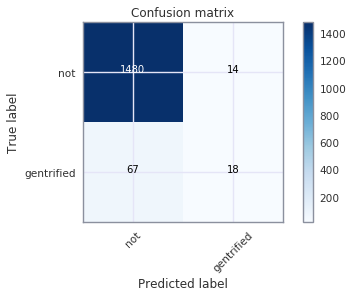

In [39]:
ypred = alg.predict(Xnew)
mtrx = confusion_matrix(ynew, ypred)

plot_confusion_matrix(mtrx, ['not', 'gentrified'])

# Diagnosing the issue

## Try scaling the data?

In [18]:
equivelent_fields = zip(idx90, idx00)

significance = 0.01

# TODO produce a histogram for each variable and compare
for field90, field00 in  equivelent_fields:
    data90 = eligible_geo[field90]
    data00 = eligible_geo[field00]
    tstat, pvalue = ttest_ind(data90, data00)
    if pvalue < significance:
        print(field90, field00, 'may have different means', pvalue)

oldsub_nataff90 oldsub_nataff00 may have different means 1.32179649743e-15
oldsub_all_sub90 oldsub_all_sub00 may have different means 2.44132431895e-28
rm_ch_per_col_since90 rm_ch_per_col_since00 may have different means 0.0
rm_per_col90 rm_per_col00 may have different means 0.0
tod90 tod00 may have different means 1.12290625606e-18
rm_per_nonwhite90 rm_per_nonwhite00 may have different means 0.0
rm_pctch_real_mrent_since90 rm_pctch_real_mrent_since00 may have different means 0.0
rm_per_all_li90 rm_per_all_li00 may have different means 0.0
rm_pctch_real_hinc_since90 rm_pctch_real_hinc_since00 may have different means 0.0
oldsub_nataff_r90 oldsub_nataff_r00 may have different means 7.22207786285e-15
rm_per_rent90 rm_per_rent00 may have different means 0.0
rm_pctch_real_mhval_since90 rm_pctch_real_mhval_since00 may have different means 0.0
oldsub_nataff_o90 oldsub_nataff_o00 may have different means 1.94387237183e-06


## Try scaling the data?

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xt = scaler.fit_transform(X)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [20]:
X_train_t, X_test_t, y_train, y_test =\
train_test_split(
    Xt, 
    y, 
    test_size=0.4,
    random_state=0
)

alg2, res = utils.xgb_cv(
    X_train_t, 
    y_train, 
    base_score=prior_prob(y_train)
)
res.iloc[-1] # The last round of cross-validation

test-auc-mean           0.962179
test-auc-std            0.014944
test-error@0.1-mean     0.065608
test-error@0.1-std      0.018752
train-auc-mean          1.000000
train-auc-std           0.000000
train-error@0.1-mean    0.017284
train-error@0.1-std     0.002286
Name: 99, dtype: float64

In [21]:
alg2.score(X_test_t, y_test)

0.97310126582278478

In [22]:
Xnew_t = scaler.transform(Xnew)
alg2.score(Xnew_t, ynew)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


0.94996833438885375